In [ ]:
# !pip install --upgrade tensorflow
# !pip install --upgrade numpy

# !pip install stable-baselines
# !pip install stable-baselines[mpi]
# !pip install gym

In [ ]:
!pip install karateclub
# import karateclub

In [ ]:
import numpy as np
# import tensorflow as tf
from google.colab import files
import networkx as nx
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.sparse import coo_array

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# from keras.preprocessing import sequence
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import BatchNormalization
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout
# from keras import regularizers
# from keras.optimizers import Adam
# from keras.models import load_model
# from keras.callbacks import ModelCheckpoint
# from scipy.sparse import coo_array


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/cora_embeddings'

Mounted at /content/drive


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Device:  cuda:0
__CUDNN VERSION: 8906
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.835660288


# Graph building, preprocessing

In [ ]:
edgelist = pd.read_csv(f"{path}/cora.cites", sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(f"{path}/cora.content", sep='\t', header=None, names=column_names)

attributes = node_data.sort_index(axis=0)
mapping = {}
list_of_index = list(attributes.index)
for i in range(len(list_of_index)):
    mapping[list_of_index[i]] = i
G = nx.relabel_nodes(Gnx, mapping)

attributes['subject'] = attributes['subject'].astype('category')
labels = attributes['subject'].cat.codes

model = karateclub.AE()
# model.fit(G, coo_array(np.array(attributes)))
# embeddings = model.get_embedding()


# Classification

In [ ]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed.
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)

    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer() #sklearn
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

class Model(nn.Module):
    def __init__(self, input_dim, nclasses):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 16)
        self.fc3 = nn.Linear(16, nclasses)

        if nclasses == 2:
            self.last_activation = nn.Sigmoid()
        else:
            self.last_activation = nn.Softmax(dim=1)

    def forward(self, x):
        # x = x.float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.last_activation(self.fc3(x))
        return x

def train_one_epoch(train_examples,
                    train_labels,
                    model,
                    optimizer,
                    loss_fn,
                    batch_size=32,
                    device='cpu'):

      #for computing loss/acc on our train dataset
      total_loss = 0
      total_correct = 0

      shuffled_indices = torch.randperm(len(train_examples))
      train_examples = train_examples[shuffled_indices]
      train_labels = train_labels[shuffled_indices]

      for i in range(0, len(train_examples), batch_size):
        #build your batch of data
        inputs = train_examples[i:i+batch_size]
        labels = train_labels[i:i+batch_size]

        #convert to tensors
        inputs = torch.tensor(inputs).float()
        labels = torch.tensor(labels)
        labels = labels.type(torch.LongTensor)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # #zero your gradients for current batch
        optimizer.zero_grad()

        #make predictions on batch
        outputs = model(inputs)

        #compute loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        #adjust learning weights
        optimizer.step()

        #calculate loss and acc
        batch_loss = loss.item()
        # total_loss += batch_loss #
        total_loss += batch_loss * batch_size
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # print(f"Batch Loss: {batch_loss}")

      # total_batches = len(train_examples) // batch_size
      # train_loss = total_loss / total_batches
      train_loss = total_loss / len(train_examples)
      train_acc = total_correct / len(train_examples)

      return train_loss, train_acc


def run_classification(dataset, labels, timeseries, r, shape, train_size, seq_len, dim, nclasses, device, verbose=True, display_cm=False):

  # split dataset intro train and val
  train_data = dataset
  train_examples, test_examples, train_labels, test_labels = train_test_split(train_data,
                                                                              labels,
                                                                              random_state=r,
                                                                              train_size = train_size,
                                                                              stratify=labels)

  # convert labels to tensor
  train_labels = torch.tensor(train_labels)
  test_labels = torch.tensor(test_labels)

  #balance out classes in dataset
  class_weights = torch.tensor(list(generate_class_weights(labels).values()))
  class_weights = class_weights.float()
  class_weights = class_weights.to(device)
  n_classes = len(class_weights)

  #pytorch model
  batch_size = 16
  model = Model(dim, nclasses)
  model = model.float()
  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  # loss_fn = torch.nn.CrossEntropyLoss()
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

  #train/fit model
  EPOCHS = 30
  epoch_number = 0
  for epoch in range(30):
    # do a pass over training data, ensuring gradient tracking is on
    model.train(True)
    avg_loss, avg_accuracy = train_one_epoch(train_examples,
                                              train_labels,
                                              model,
                                              optimizer,
                                              loss_fn,
                                              batch_size=batch_size,
                                              device=device)
    if verbose:
      print(f"EPOCH {epoch_number + 1}:")
      print(f"Average Loss: {avg_loss}")
      print(f"Average Accuracy: {avg_accuracy}")

    epoch_number += 1

  # get predictions (multiclass) on test set
  model.eval()
  final_test_preds = []
  with torch.no_grad():
    test_preds = model(torch.tensor(test_examples).float().to(device))
    for i in range(len(test_preds)):
      final_test_preds.append(test_preds[i].argmax().item())

  if display_cm:
    ConfusionMatrixDisplay.from_predictions(test_labels, final_test_preds)
  return accuracy_score(test_labels, np.array(final_test_preds)), model


In [ ]:
# Load cora dataset in
#cora.tsv is the file containing node embeddings using karateclub.AE(). I is a 2708x64 array
path = '/content/drive/MyDrive/cora_embeddings'
dataset = np.genfromtxt(fname=f"{path}/cora.tsv", delimiter="\t")
labels = np.genfromtxt(fname=f"{path}/cora_labels.tsv")

print(dataset.shape)
print(labels.shape)

(2708, 64)
(2708,)


<ipython-input-7-6f590b515157>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


EPOCH 1:
Average Loss: 1.748544545035249
Average Accuracy: 0.5113456464379947
EPOCH 2:
Average Loss: 1.0603086134374613
Average Accuracy: 0.7435356200527704
EPOCH 3:
Average Loss: 0.6242170162754512
Average Accuracy: 0.807915567282322
EPOCH 4:
Average Loss: 0.5255994801785512
Average Accuracy: 0.8211081794195251
EPOCH 5:
Average Loss: 0.47480666681455747
Average Accuracy: 0.8369393139841689
EPOCH 6:
Average Loss: 0.4650111580901536
Average Accuracy: 0.8443271767810027
EPOCH 7:
Average Loss: 0.4439459921502186
Average Accuracy: 0.8517150395778365
EPOCH 8:
Average Loss: 0.4136697796844241
Average Accuracy: 0.8617414248021108
EPOCH 9:
Average Loss: 0.39211259328595566
Average Accuracy: 0.8686015831134565
EPOCH 10:
Average Loss: 0.3848328490999569
Average Accuracy: 0.8701846965699208
EPOCH 11:
Average Loss: 0.3645946376870993
Average Accuracy: 0.8712401055408971
EPOCH 12:
Average Loss: 0.35203710294336
Average Accuracy: 0.8854881266490765
EPOCH 13:
Average Loss: 0.346785186022756
Average A

<ipython-input-7-6f590b515157>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


EPOCH 1:
Average Loss: 1.7302994861451806
Average Accuracy: 0.46226912928759895
EPOCH 2:
Average Loss: 0.9637227488696418
Average Accuracy: 0.7662269129287599
EPOCH 3:
Average Loss: 0.5733805044974375
Average Accuracy: 0.8200527704485489
EPOCH 4:
Average Loss: 0.47282011521523104
Average Accuracy: 0.8411609498680739
EPOCH 5:
Average Loss: 0.44655770248976734
Average Accuracy: 0.8490765171503958
EPOCH 6:
Average Loss: 0.41605357834405826
Average Accuracy: 0.8596306068601584
EPOCH 7:
Average Loss: 0.3925987609772695
Average Accuracy: 0.8691292875989446
EPOCH 8:
Average Loss: 0.38293919601037824
Average Accuracy: 0.8712401055408971
EPOCH 9:
Average Loss: 0.3830162433332378
Average Accuracy: 0.8717678100263853
EPOCH 10:
Average Loss: 0.35925349585299127
Average Accuracy: 0.8765171503957784
EPOCH 11:
Average Loss: 0.35169217454412055
Average Accuracy: 0.8807387862796834
EPOCH 12:
Average Loss: 0.3316078568511399
Average Accuracy: 0.887071240105541
EPOCH 13:
Average Loss: 0.3275669631354098


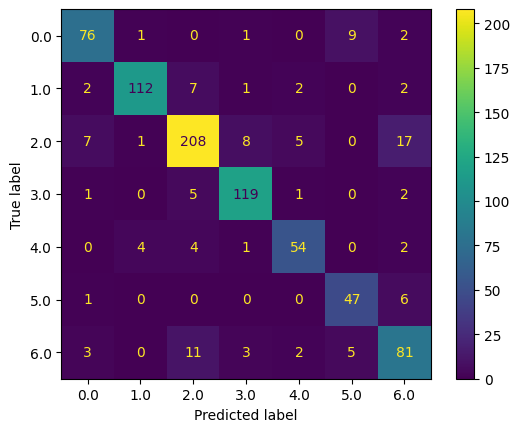

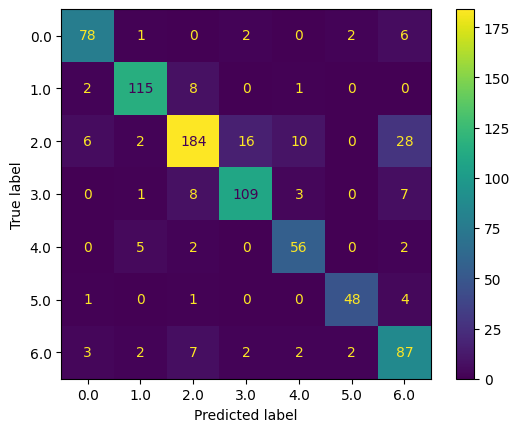

In [ ]:
#run classification
acc = []
for i  in range(2):
  a, model = run_classification(dataset,
                                labels,
                                timeseries=False,
                                r = i+10,
                                shape = (2708, 64),
                                train_size = 0.7,
                                seq_len=10,
                                dim = 64,
                                nclasses = 7,
                                device=device,
                                display_cm=True)
  acc.append(a)

# train loss in tensorflow: 0.3039
# train acc in tensorflow: 0.8871

# train loss in pytorch: 1.2875
# train acc in pytorch: 0.9065

In [ ]:
print(np.mean(acc), np.std(acc))

# tensorflow values:
# 0.8373923739237392 0.009806214724720668

# pytorch values:
# 0.8348093480934808 0.010695450287000415

0.852029520295203 0.014291980765235376


# Network Simulation

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import numpy as np
import math
from scipy.sparse import coo_array
from sklearn.neighbors import NearestNeighbors

#returns a graph, its node attributes (of size <nodes> x 2), node labels (list of size <nodes>), and positions of nodes for drawing purposes
#To get embedding of this graph, call embedding_model.fit(g, a)

def make_network(nodes, k, draw=False):
  random_points = np.random.rand(nodes, 2) * 10
  if draw:
    plt.figure(figsize=(10,5))
    plt.scatter(random_points[:, 0], random_points[:, 1])

  # initialize graph
  g = nx.Graph()
  pos = {}


  # Find nearest neighbor for each point
  distances, indices = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(random_points).kneighbors(random_points)
  for i in range(len(random_points)):
    g.add_node(i) #add node i to our graph
    pos[i] = (random_points[i, 0], random_points[i, 1])
    for j in range(len(indices[i])-1):
        g.add_edge(i, indices[i][j+1])

  labels = np.zeros(nodes)
  # seq = list(range(nodes))
  select_1s = []
  select_2s = []
  for c in nx.connected_components(g):
      seq = list(c)
      s1 = random.sample(seq, math.ceil(len(c)/15))
      labels[s1] = 1
      select_1s += s1
      seq = [i for i in list(c) if i not in s1]
      s2 = random.sample(seq, math.ceil(len(c)/15))
      labels[s2] = 2
      select_2s += s2
  # print(labels)

  plt.figure(figsize=(10,5))
  color = ['blue']*nodes
  lst = list(labels)
  for i in range(len(lst)):
    if lst[i] == 1:
      color[i] = 'pink'
    elif lst[i] == 2:
      color[i] = 'yellow'
  if draw:
    nx.draw_networkx(g, pos = pos, node_color = color, node_size = 150, font_size= 8)

  # class_ = 1
  ind1 = 0
  ind2 = 0

  while len(select_1s) + len(select_2s) < nodes:
      # print(len(select_1s) + len(select_2s))

      if random.random() >= 0.5: #add class 1
          if random.random() > 0.6:
              source = select_1s[ind1]
          else:
              source = random.choice(select_1s)
          # class_ = 2
          flag = 0
          for n in g[source]:
              if labels[n] == 0:
                  flag = 1
                  labels[n] = 1
                  select_1s.append(n)
          if flag == 1:
              ind1 += 1

      else: #add class 2

          if random.random() > 0.6:
              source = select_2s[ind2]
          else:
              source = random.choice(select_2s)
          # class_ = 1
          flag = 0
          for n in g[source]:
              if labels[n] == 0:
                  labels[n] = 2
                  select_2s.append(n)
          if flag == 1:
              ind2 += 1


  # return g, coo_array(random_points), labels-1, pos
  return g, random_points, labels-1, pos


In [ ]:
g, a, l, p = make_network(nodes=50, k=4)

<Figure size 1000x500 with 0 Axes>

In [ ]:
l+1

array([2., 2., 1., 2., 2., 2., 2., 1., 1., 2., 2., 1., 2., 1., 2., 2., 2.,
       1., 1., 2., 1., 2., 2., 2., 2., 1., 1., 2., 1., 1., 2., 2., 1., 2.,
       2., 2., 2., 1., 2., 1., 1., 1., 1., 1., 2., 2., 1., 2., 2., 1.])

In [ ]:
g #our graph of 50 nodes
a #node attributes - shape: 50x2
l #node labels - binary (0 or 1)
p #node positions

a

<50x2 sparse array of type '<class 'numpy.float64'>'
	with 100 stored elements in COOrdinate format>

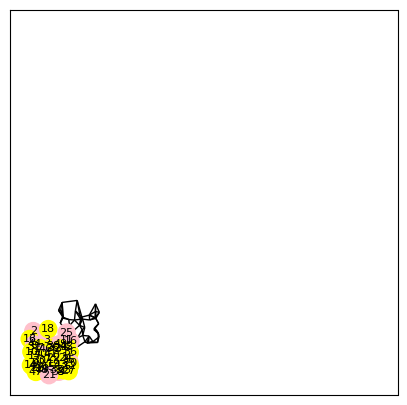

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(5,5))
color = ['pink' if i == 1 else 'yellow' for i in l]
nx.draw_networkx(g, pos = p, node_color = color, node_size = 150, font_size= 8)

# Environment building

In [ ]:
import numpy as np
import networkx as nx
import gym
from gym import spaces
import copy

class OldGraphEnvironment(gym.Env):
    def __init__(self, num_nodes, num_features, embedding_model, G, attributes, labels):
        self.num_nodes = num_nodes
        self.num_features = num_features

        # Define action and observation spaces
        self.action_space = spaces.MultiDiscrete([num_nodes, num_nodes])
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_features), dtype=np.float32)
        self.iter = 0

        # Initialize state (empty graph)
        self.G = G
        g = nx.Graph()
        g.add_nodes_from(self.G) #what is big G? our cora dataset/empty graph? --> need to pass in to GraphEnv class
        self.graph = g
        self.attributes = attributes

        # get embedding of empty graph
        embedding_model.fit(copy.deepcopy(self.graph), coo_array(np.array(self.attributes))) #what is coo array?
        self.state = embedding_model.get_embedding()#get embedding of empty graph

        self.dataset = embedding_model.get_embedding() #50,64
        self.labels = np.array(labels) #50,1


    def step(self, action):
        node1, node2 = action
        self.iter += 1

        #have to implement action masking instead. Goes in DQN module
        if self.graph.has_edge(node1, node2):
          #do nothing
          reward = 0

        else:
          # Add edge to graph
          self.graph.add_edge(node1, node2)


          embedding_model.fit(copy.deepcopy(self.graph), coo_array(np.array(self.attributes)))
          self.state = embedding_model.get_embedding()#get embedding of empty graph


          # Calculate reward
          print('state shape:', self.state.shape)
          reward = self.calculate_reward(self.state) #get classification acc

        # Check termination condition
        done = False
        if self.graph.has_edge(1696, 2392) or self.iter >= 10:
            done = True

        return self.state, reward, done, {}

    def reset(self):
        # Reset state and graph (to initial empty graph-->graph with no edges)
        g = nx.Graph()
        g.add_nodes_from(self.G)
        self.graph = g

        embedding_model.fit(copy.deepcopy(self.graph), coo_array(np.array(self.attributes)))
        self.state = embedding_model.get_embedding()#get embedding of empty graph

        return self.state

    def calculate_reward(self, curr_state):
       print('Calculating reward...')
       print('Curr state shape:', curr_state.shape)
       #instead of self.dataset, we should feed in the new state (graph) with the
       #new edge added inorder to calculate the reward (classification accuracy)
       #yielded by our new state as a result of our action
       #self.labels can stay the same bc node classes will not change w/ the addition of edges

       acc, model = run_classification(curr_state,
                                self.labels,
                                timeseries=False,
                                r = i+10,
                                shape = curr_state.shape,
                                train_size = 0.7,
                                seq_len=10,
                                dim = 64,
                                nclasses = len(np.unique(self.labels)),
                                device=device,
                                verbose=False)
       return acc


In [ ]:
#updated with namrata's changes
import numpy as np
import networkx as nx
import gym
from gym import spaces

class GraphEnvironment(gym.Env):
    def __init__(self, num_nodes, num_features, embedding_model, G, attributes, labels):
        self.num_nodes = num_nodes
        self.num_features = num_features
        self.current_return = 0
        self.reward = 0

        # Define action and observation spaces
        # self.action_space = spaces.MultiDiscrete([num_nodes, num_nodes])
        self.action_space = spaces.Discrete(num_nodes**2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_features), dtype=np.float32)
        self.iter = 0

        # Initialize state (empty graph)
        self.G = G
        g = nx.Graph()
        g.add_nodes_from(self.G) #what is big G? our cora dataset/empty graph? --> need to pass in to GraphEnv class
        self.graph = g
        self.attributes = attributes

        # get embedding of empty graph
        embedding_model.fit(copy.deepcopy(self.graph), coo_array(copy.deepcopy(np.array(self.attributes)))) #what is coo array?
        self.state = embedding_model.get_embedding()#get embedding of empty graph
        self.labels = np.array(labels) #50,1


    def step(self, action):
        node1, node2 = int(action[0][0] % self.num_nodes), int(action[0][0] / self.num_nodes)
        self.iter += 1

        #have to implement action masking instead. Goes in DQN module
        if self.graph.has_edge(node1, node2):
          #do nothing
          reward = 0

        else:
          # Add edge to graph
          self.graph.add_edge(node1, node2)


          embedding_model.fit(copy.deepcopy(self.graph), coo_array(np.array(copy.deepcopy(self.attributes))))
          self.state = embedding_model.get_embedding()#get embedding of empty graph


          # Calculate reward
          reward = self.calculate_reward() #get classification acc

        # Check termination condition
        done = False
        if self.graph.has_edge(4, 23) or self.iter >= 100:
            done = True

        return self.state, reward, done, {}

    def reset(self):
        # Reset state and graph
        g = nx.Graph()
        g.add_nodes_from(self.G)
        self.graph = g


        embedding_model.fit(copy.deepcopy(self.graph),  coo_array(np.array(copy.deepcopy(self.attributes))))
        self.state = embedding_model.get_embedding()#get embedding of empty graph


        return self.state

    def calculate_reward(self):

       acc = []
       for i in range(5):
        a, model = run_classification(self.state,
                          self.labels,
                          timeseries = False,
                          r = i+10,
                          shape = (50, 64),
                          train_size = 0.7,
                          seq_len=10,
                          dim = 64,
                          nclasses = 2,
                          device=device, verbose=False)
        acc.append(a)

       accuracy = np.mean(acc)
       print("Accuracy = ", accuracy)
       print("Previous Return= ", self.current_return)
       self.current_return = accuracy-self.reward
       self.reward = accuracy
       print("Current Return= ", self.current_return)

       return self.current_return


# # Test drive
# env = GraphEnvironment(num_nodes=50, num_features=64)
# state = env.reset()
# done = False
# total_reward = 0

# while not done:
#     action = env.action_space.sample()  # Random action for demonstration
#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward

# print("Total reward:", total_reward)
# print(env.iter)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
np.random.seed(1234)

#define num of nodes and num of features for G (reduce graph size so it runs faster)
num_nodes = 50
num_features = 2 #or 64??

# simulate network data
G_sim, attributes_sim, labels_sim, pos_sim = make_network(nodes=num_nodes, k=4)

#build embedding model
embedding_model = karateclub.AE()
embedding_model.fit(G_sim, coo_array(np.array(attributes_sim)))
dataset_sim = embedding_model.get_embedding() #50,64
labels_sim = np.array(labels_sim) #50,1

# Example usage of custom graph environment
# env = GraphEnvironment(num_nodes=num_nodes,
#                        num_features=num_features,
#                        embedding_model=embedding_model,
#                        G=G,
#                        attributes=attributes)

env = GraphEnvironment(num_nodes=num_nodes,
                       num_features=num_features,
                       embedding_model=embedding_model,
                       G=G_sim,
                       attributes=attributes_sim,
                       labels=labels_sim)
state = env.reset()
done = False
total_reward = 0

i = 0
# while not done:
#     print(f"Getting action {i}")
#     action = env.action_space.sample()  # Random action for demonstration
#     next_state, reward, done, _ = env.step(action)
#     print(f"Reward: {reward}")
#     total_reward += reward
#     i += 1

# print("Total reward:", total_reward) #Total reward: 6.723247232472325, took 10 iterations (actions)
# print(env.iter)

/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


<Figure size 1000x500 with 0 Axes>

### Stable baselines DQN (doesn't work :( )

In [ ]:
import gym

# from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN

env = gym.make('CartPole-v1')
# env = GraphEnvironment(num_nodes=5, num_features=3)

model = DQN(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=10)
# model.save(f"{path}/deepq_graph")

# del model # remove to demonstrate saving and loading

# model = DQN.load(f"{path}/deepq_graph")

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()


### PyTorch DQN

In [ ]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from gym.spaces import MultiDiscrete

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
embedding_model = karateclub.AE()

# env = gym.make("CartPole-v1")
# env = GraphEnvironment(num_nodes=5, num_features=3)
env = GraphEnvironment(num_nodes=num_nodes,
                       num_features=num_features,
                       embedding_model=embedding_model,
                       G=G_sim,
                       attributes=attributes_sim,
                       labels=labels_sim)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Transition tuple represents a single transition in our environment
# It maps (state, action) pairs to their (next_state, reward) result
# The state being the screen difference image as described later on
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# ReplayMemory class is a cyclic buffer of bounded size that holds the transitions observed RECENTLY
# It implements a .sample() method for selecting a random batch of transitions for training. This
# decorrelates transitions and helps to greatly stabilize & improve the DQN training procedure
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# DQN Model
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # self.layer1 = nn.Linear(n_observations, 128)
        # self.layer2 = nn.Linear(128, 128)

        self.layer1 = nn.Linear(50*64, 128) #n_observations is supposed to be flattened version of 2D input. Try Conv2d later. Classification works without conv because each input is a row in that case, not a matrix
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
env.reset() #returns the graph of node embeddings of shape (num_nodes, 64)

array([[ 0.02496081,  0.02925937,  0.02494304, ...,  0.07970247,
        -0.7176541 , -0.7351445 ],
       [ 0.0220677 ,  0.00523767, -0.01126242, ...,  0.1452846 ,
        -0.6176656 , -0.6122172 ],
       [ 0.00937379, -0.02390207, -0.01755167, ...,  0.10621306,
        -0.7525901 , -0.53642327],
       ...,
       [ 0.01263396, -0.01773443, -0.00082828, ...,  0.58611476,
        -0.05917264, -0.445608  ],
       [ 0.02495251,  0.01973666,  0.02940916, ...,  0.10768364,
        -0.5770547 , -0.6656566 ],
       [-0.00164827,  0.01343475,  0.01684589, ...,  0.7793641 ,
        -0.7641972 , -0.56971514]], dtype=float32)

In [ ]:
#Training
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon - MR: when/how does EPS get updated?
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
# n_actions = (num_nodes)**2 bc an 'action' = adding an edge b/w two nodes
n_actions = env.num_nodes ** 2 #env.action_space[0].n #env.action_space[1].n

# Get the number of state observations
state = env.reset() #set the initial state
n_observations = 50*64 #state.shape[0] * state.shape[1] #50 * 64 #WE CHANNGED SO IF IT BREAKS THIS IS WHY

print('num_actions:', n_actions)
print('num_observations:', n_observations)
policy_net = DQN(n_observations, n_actions).to(device) #n_observations should be 64
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) #loading model

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

#EPS Greedy Action Selection
# someitmes we use our model to choose the action, sometimes we'll just sample one uniformly
# helps balance exploration with exploitation (picking best option)
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    print(eps_threshold)
    # print('if-statement action:', policy_net(torch.flatten(state, start_dim = 1)).max(1).indices)
    # print('else-statement action:', torch.tensor(env.action_space.sample(), device=device, dtype=torch.long))
    # return torch.tensor(env.action_space.sample(), device=device, dtype=torch.long) #for now just return this
    if sample > eps_threshold:
        print('sample > eps_threshold...')
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(torch.flatten(state, start_dim = 1)).max(1).indices.view(1, 1)
            # return policy_net(torch.flatten(state, start_dim = 1)).max(1).indices[0] #modified on 4/11 by Namrata, flattened version. Should check out Conv2d later

            # return policy_net(state).max(1).indices[0:first_half].view(1, 1), policy_net(state).max(1).indices[first_half:].view(1, 1) #MR: this is what we would modify w/ what Sam suggested
    else:
        print('else statement of select action')
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        # return torch.tensor(env.action_space.sample(), device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


num_actions: 2500
num_observations: 3200


In [ ]:
#training loop

# optimize_model() performs a single step of the optimization.
#  1. Sample a batch
#     Concat all the tensors into one
#     Compute Q(s,a) and V(s_(t+1)) = maxQ(s_(t+1), a) & combine into our loss
# 2. Set V(s) = 0 if s is a terminal state
# 3. Use a target network to compute V(s_(t+1))
#    Target network is updated at every step w/ a soft update (???)
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    print("**************", len(batch.action))
    state_batch = torch.flatten(torch.tensor(batch.state), start_dim = 1)
    action_batch = torch.tensor(batch.action)
    reward_batch = torch.tensor(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#commence training
if torch.cuda.is_available():
    num_episodes = 100 #100 #600
else:
    num_episodes = 50
x  = 0
for i_episode in range(num_episodes):
    x += 1
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        print('Selecting an action...')
        print('shape of state going into memory:', state.shape)
        action_tensor = select_action(state) #exploit or explore
        action = action_tensor.tolist()
        print("&&&&&&&&&&&&&&&", action)
        # observation, reward, terminated, truncated, _ = env.step(action.item())
        observation, reward, terminated, _ = env.step(action)
        reward = torch.tensor([reward], device=device)
        done = terminated #or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state


        if x >= 10 and x % 10 == 0:  # added this if statement on 04/15/2024 to see if training after every few time steps is better
          # Perform one step of the optimization (on the policy network)
          optimize_model()

          # Soft update of the target network's weights
          # θ′ ← τ θ + (1 −τ )θ′
          target_net_state_dict = target_net.state_dict()
          policy_net_state_dict = policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
          target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.4455382844955124
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.49333333333333335
Previous Return=  0.05333333333333318
Current Return=  -0.013333333333333253


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.4451429439142526
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.52
Previous Return=  -0.013333333333333253
Current Return=  0.026666666666666672


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.4447479984759696
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.5066666666666666
Previous Return=  0.026666666666666672
Current Return=  -0.01333333333333342


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.44435344778571795
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.5333333333333334
Previous Return=  -0.01333333333333342
Current Return=  0.02666666666666684


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.44395929144894697
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.5466666666666666
Previous Return=  0.02666666666666684
Current Return=  0.013333333333333197


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.4435655290715003
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.4533333333333333
Previous Return=  0.013333333333333197
Current Return=  -0.09333333333333332


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.4431721602596155
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.4666666666666666
Previous Return=  -0.09333333333333332
Current Return=  0.013333333333333308


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.44277918461992366
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.52
Previous Return=  0.013333333333333308
Current Return=  0.0533333333333334


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.4423866017594492
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.48
Previous Return=  0.0533333333333334
Current Return=  -0.040000000000000036


/usr/local/lib/python3.10/dist-packages/karateclub/node_embedding/attributed/ae.py:78: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  [model.docvecs[str(n)] for n in range(self.graph.number_of_nodes())]


Selecting an action...
shape of state going into memory: torch.Size([1, 50, 64])
0.44199441128560923
sample > eps_threshold...
&&&&&&&&&&&&&&& [[441]]


<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
<ipython-input-5-96df99f8946b>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Accuracy =  0.4533333333333333
Previous Return=  -0.040000000000000036
Current Return=  -0.026666666666666672
************** 128


TypeError: flatten(): argument 'input' (position 1) must be Tensor, not tuple

In [ ]:
run_classification(env.state, labels_sim, timeseries = False, r = 0, train_size = 0.7, dim = 64, nclasses = 2, device = device)

NameError: name 'run_classification' is not defined

In [ ]:
3200*128

409600